# Dimensionality Reduction for High-Dimensional Time Series

In this example, we reduce the dimensionality of a time series input from
1000 features to 100. 

### Import some libraries

In [5]:
import numpy as np
import pandas as pd

from scipy.stats import expon, randint
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import KernelPCA, PCA

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt



In [27]:
# import your tools for cleaning, encoding if needed, and data scaling

import data_cleaning
import data_encoding
import data_scaling

### Read the raw data 

In [30]:
# Load raw data 
X_data_all = pd.read_csv('high_dim_data.csv')
print(X_data_all.shape)

/Users/DBetancourt/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1105,1106) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(79073, 1107)


In [31]:
X_data_all.head()

,timestamp,None_avg,None_max,None_median,None_min,None_p95,None_var,anti_entropy_saturation_avg,anti_entropy_saturation_max,anti_entropy_saturation_median,...,write_view_ratio_avg,write_view_ratio_avg_pit,write_view_ratio_max,write_view_ratio_max_pit,write_view_ratio_median,write_view_ratio_median_pit,write_view_ratio_sum,write_view_ratio_sum_pit,label,issue_id
0,2019-02-01 00:01:58.699,1.333333,2.0,1.0,1.0,1.9,0.353553,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CASSANDRA_LEVELED_COMPACTION_MISUSE,4018b55b-3996-11e9-943b-42010a8a0058
1,2019-02-01 00:02:20.877,0.000000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2019-02-01 00:02:23.539,0.000000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,2019-02-01 00:02:44.801,0.000000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CASSANDRA_TOMBSTONE_ACCUMULATION,e4fa365b-3995-11e9-8a7e-42010a8a004f
4,2019-02-01 00:02:44.973,0.000000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CASSANDRA_LWT_MISUSE,899c0c76-3996-11e9-9335-42010a8a0015


### Read the raw data and clean it


In [32]:
# data cleaning module deletes columns with all nan or 0s 
# can add more data cleaning checks as needed

X_data_clean = data_cleaning.cleaner('high_dim_data.csv')
print(X_data_clean.shape)

/Users/DBetancourt/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (1105,1106) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(79073, 569)


In [33]:
X_data_clean.head()

,timestamp,None_avg,None_max,None_median,None_min,None_p95,None_var,batch_remove_batch_remove_dropped_var,batch_store_batch_store_dropped_var,blocked_anti_entropy_var,...,write_two_timeouts_count_var,write_two_unavailables_count_var,write_unavailables_count_avg,write_unavailables_count_max,write_unavailables_count_median,write_unavailables_count_min,write_unavailables_count_p95,write_unavailables_count_var,label,issue_id
0,2019-02-01 00:01:58.699,1.333333,2.0,1.0,1.0,1.9,0.353553,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,NaN,CASSANDRA_LEVELED_COMPACTION_MISUSE,4018b55b-3996-11e9-943b-42010a8a0058
1,2019-02-01 00:02:20.877,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,84.333333,253.0,0.0,0.0,227.7,1.414214,NaN,NaN
2,2019-02-01 00:02:23.539,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,2019-02-01 00:02:44.801,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,NaN,CASSANDRA_TOMBSTONE_ACCUMULATION,e4fa365b-3995-11e9-8a7e-42010a8a004f
4,2019-02-01 00:02:44.973,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,NaN,CASSANDRA_LWT_MISUSE,899c0c76-3996-11e9-9335-42010a8a0015


### Read the raw data and clean it

In [13]:
# after cleaning the data we're ready to encode any categorical features and labels
X_data_enc, y_data_enc = data_encoding.data_enc(X_data_clean)

In [22]:
# Do some nan imputation. If there's a large number of nans in the features we cannot do dimensionality reduction with them.
X_data_enc_clean = X_data_enc.fillna(method='ffill')
X_data_enc_clean.fillna(value=0, inplace=True)
X_data_enc_clean.head()

,timestamp,cluster_id,cluster_name,customer_id,service,None_avg,None_max,None_median,None_min,None_p95,...,write_timeouts_count_var,write_two_failures_count_var,write_two_timeouts_count_var,write_two_unavailables_count_var,write_unavailables_count_avg,write_unavailables_count_max,write_unavailables_count_median,write_unavailables_count_min,write_unavailables_count_p95,write_unavailables_count_var
0,0.0,3.0,0.0,0.0,0.0,1.333333,2.0,1.0,1.0,1.9,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,1.0,2.0,2.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1.131371,0.0,0.0,0.0,84.333333,253.0,0.0,0.0,227.7,1.414214
2,2.0,7.0,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1.131371,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.414214
3,3.0,8.0,6.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1.131371,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.414214
4,4.0,5.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1.131371,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.414214


### Scale the data 

In [16]:
# As for any data, neeed to scale it. Here using standardization
X_data_std,_,scaler_std,_ = data_scaling.scale_data(X_data_enc_clean)

In [11]:
# now we're ready to do dimensionality reduction.

In [17]:
# load the dimensionality reduction mudule
# first let's do some exploration with PCA
# here we examine by hand, which features make the most sense, and also test them out with a 
# classifier
import dim_red

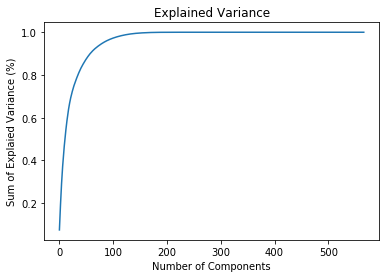

In [18]:
dim_red.dim_exploration(X_data_std)

In [ ]:
# we can see from the explained variance that we need about 100 features 

In [19]:
# doign only PCA with 100 components
X_pca  = dim_red.dim_red_pca_only(pd.DataFrame(X_data_std),100)

In [21]:
X_pca.shape

(79073, 100)

Additionally, use a simple supervised model to compare out-of-sample accuracy using other dimensionality reduction 
and feature extraction techniques. Now we will use a reduced dataset to embed it and train a deep model.